# Active learning

This is an example of how to use REINVENT with Maize in a reinforcement learning workflow using active learning. This workflow builds on both the simple docking workflow and the REINVENT workflow by adding an existing active learning component to drastically accelerate the reinforcement learning loop.

The general idea here is to only run the scoring of a batch of molecules on a subset (using our accurate but slow *oracle*, docking in this case), and predict the other scores using a simple machine learning model (our *proxy* or *surrogate*). Every iteration the proxy model is re-trained using the output of the oracle. This allows us to skip a large number of slow score evaluations and progress through the reinforcement learning loop faster.

.. caution::
   This is an example workflow not meant for production use, none of the settings are optimised for scientific accuracy or efficiency. It is only meant to showcase Maize's complex workflow capabilities.

## Imports

We begin with all top-level requirements and imports, and ensure our software dependencies are setup correctly.

In [1]:
from pathlib import Path
from tempfile import mkdtemp

from maize.core.workflow import Workflow
from maize.steps.io import Void
from maize.steps.mai.cheminformatics import ExtractScores
from maize.steps.mai.docking.adv import AutoDockGPU
from maize.steps.mai.molecule import Smiles2Molecules
from maize.steps.mai.misc import ReInvent, ActiveLearning, ActiveLearningProgress, EpsilonGreedy

## Workflow
We use the same configuration as before, note that you will need to setup the required software yourself.

In [2]:
flow = Workflow(name="al", level="info", cleanup_temp=False)
flow.config.update(Path("docking-example-config.toml"))

We begin by creating all the required nodes. The workflow will again be circular, with the `ReInvent` node creating SMILES and accepting scores. We again embed the molecules first, and then send them to the `ActiveLearning` graph, which handles the logic. This graph requires us to supplement it with our oracle scoring function (`AutoDockGPU` again) and an acquisition function determining which molecules get sent to the oracle. We additionally add an `ActiveLearningProgress` node to save information over the course of our run, and extract the scores to send them back to REINVENT.

In [3]:
rnve = flow.add(ReInvent)
embe = flow.add(Smiles2Molecules, loop=True)
actl = flow.add(ActiveLearning)
alpr = flow.add(ActiveLearningProgress, name="log")
acqu = flow.add(EpsilonGreedy, loop=True)
dock = flow.add(AutoDockGPU, loop=True)
void = flow.add(Void)
scor = flow.add(ExtractScores, loop=True)

Everything's connected up again as before:

In [4]:
flow.connect_all(
    (rnve.out, embe.inp),
    (embe.out, actl.inp),
    (actl.out_oracle, dock.inp),
    (dock.out_scores, void.inp),
    (dock.out, actl.inp_oracle),
    (actl.out, alpr.inp),
)
flow.connect_all(
    (actl.out_acq, acqu.inp),
    (acqu.out_oracle, actl.inp_acq_oracle),
    (acqu.out_surrogate, actl.inp_acq_surrogate),
    (alpr.out, scor.inp),
    (scor.out, rnve.inp),
)

### Parameters
Parameters required for this workflow are the Reinvent configuration, the docking grid, and the Qptuna config (for the proxy model).

In [5]:
rnv_config = Path("../maize/steps/mai/misc/data/input-intercept.toml")
prior = Path("../maize/steps/mai/misc/data/reinvent.prior")
grid = Path("../maize/steps/mai/docking/data/1uyd.tar")
qptuna_config = Path("../maize/steps/mai/misc/data/qptuna.json")

tmp = Path(mkdtemp())

In [6]:
# The REINVENT configuration, excluding any entries for maize (these will be added automatically)
rnve.configuration.set(rnv_config)
rnve.prior.set(prior)
rnve.agent.set(prior)

# The maximum number of RL epochs
rnve.max_epoch.set(50)

# Settings to transform the docking score to a value between 0 and 1, with 1 being favourable, using a sigmoid
rnve.low.set(-10.0)
rnve.high.set(-5.0)
rnve.reverse.set(True)

# Number of molecules to generate each epoch
rnve.batch_size.set(32)

# Docking grid for 1UYD
dock.inp_grid.set(grid)

# Deactivate constraints from the grid
dock.constraints.set(False)

# The number of latest molecules to use for training the surrogate model
actl.n_train.set(128)

# The number of warmup (no training), pooling (training only, no prediction), and production (full active learning) rounds
actl.epochs.set([0, 1, -1])

# The configuration for the proxy model
actl.proxy_config.set(qptuna_config)

# The location for the created proxy model
actl.proxy_model.set(tmp / "model.pkl")

# The location for the training pool
actl.proxy_pool.set(tmp / "pool.csv")

# The number of molecules to send to the oracle (the rest are sent to the proxy)
acqu.n_oracle.set(8)

# The fraction of molecules oracle molecules to be sampled randomly
acqu.epsilon.set(0.2)

# Save epoch information in our tmp folder
alpr.save_epochs.set(True)
alpr.save_location.set(tmp)

### Check
If this method doesn't throw an exception, we have connected everything correctly and set all required parameters.

In [7]:
flow.check()

### Topology
We can visualize our workflow by simply showing the workflow object representation (or using `flow.visualize()` outside of notebooks).

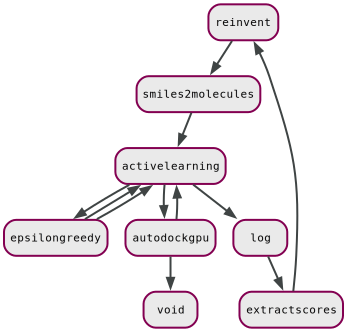

In [8]:
flow.visualize(max_level=0, labels=False)

## Run
Run the workflow, it will exit once REINVENT has completed all iterations

In [ ]:
flow.execute()

### Analysis

We can now have a look at the results of our active learning run, and see if the score improved over time.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We load the resulting CSVs containing the generated SMILES and resulting scores / predictions for each epoch...

In [11]:
scores = []
for i in range(rnve.max_epoch.value):
    raw = pd.read_csv(tmp / f"epoch-{i}.csv")
    energies = raw[raw["score_type"] == "oracle"]["energy"]
    
    # Unfortunately no way to round-trip with arrays in cells, so we need this ugly hack to parse back the values
    energies = np.stack(energies.apply(lambda txt: np.fromstring(txt.strip("[").strip("]"), sep=" ")).values)
    scores.append(energies[:, 0].mean())

... and plot the results. We do not have many oracle calls here, so we won't expect to see a large improvement. But with significantly more iterations we should pick up a strong signal.

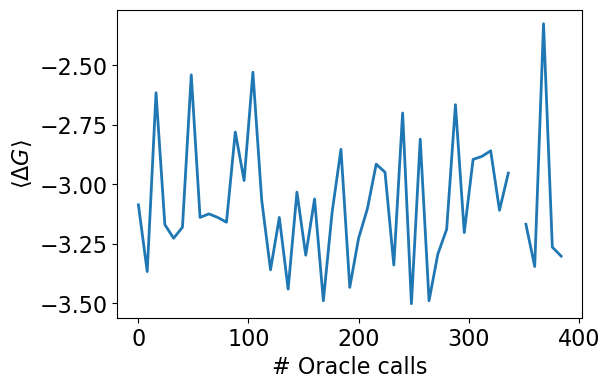

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(8 * np.arange(rnve.max_epoch.value), scores, linewidth=2)
ax.set_xlabel("# Oracle calls", fontsize=16)
ax.set_ylabel(r"$\langle \Delta G \rangle$", fontsize=16)
ax.tick_params(labelsize=16)